# Exercise 4: Circuit Decomposition
Wow! If you managed to solve the first three exercises, congratulations! The fourth problem is supposed to puzzle even the quantum experts among you, so don’t worry if you cannot solve it. If you can, hats off to you!

You may recall from your quantum mechanics course that quantum theory is unitary. Therefore, the evolution of any (closed) system can be described by a unitary. But given an arbitrary unitary, can you actually implement it on your quantum computer?

**"A set of quantum gates is said to be universal if any unitary transformation of the quantum data can be efficiently approximated arbitrarily well as a sequence of gates in the set."** (https://qiskit.org/textbook/ch-algorithms/defining-quantum-circuits.html)

Every gate you run on the IBM Quantum Experience is transpiled into single qubit rotations and CNOT (CX) gates. We know that these constitute a universal gate set, which implies that any unitary can be implemented using only these gates. However, in general it is not easy to find a good decomposition for an arbitrary unitary. Your task is to find such a decomposition.

You are given the following unitary:

#### What circuit would make such a complicated unitary?

Is there some symmetry, or is it random? We just updated Qiskit with the introduction of a quantum circuit library (https://github.com/Qiskit/qiskit-terra/tree/master/qiskit/circuit/library). This library gives users access to a rich set of well-studied circuit families, instances of which can be used as benchmarks (quantum volume), as building blocks in building more complex circuits (adders), or as tools to explore quantum computational advantage over classical computation (instantaneous quantum polynomial complexity circuits).

In [1]:
from qiskit import QuantumCircuit
from qiskit import *
from may4_challenge.ex4 import check_circuit, submit_circuit
from qiskit.transpiler.passes import Unroller
from qiskit import Aer
from qiskit import Aer, QuantumCircuit, execute
from qiskit.visualization import plot_histogram
from IPython.display import display, Math, Latex

from may4_challenge import plot_state_qsphere
from may4_challenge.ex1 import minicomposer
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from may4_challenge.ex4 import get_unitary
import numpy as np
from math import pi
import pandas as pd
import matplotlib.pylab as plt
from qiskit.aqua.components.optimizers import AQGD,ADAM,SLSQP

**Using only single qubit rotations and CNOT gates, find a quantum circuit that approximates that unitary $U$ by a unitary $V$ up to an error $\varepsilon = 0.01$, such that $\lVert U - V\rVert_2 \leq \varepsilon$ !** 

Note that the norm we are using here is the spectral norm, $\qquad \lVert A \rVert_2 = \max_{\lVert \psi \rVert_2= 1} \lVert A \psi \rVert$.

This can be seen as the largest scaling factor that the matrix $A$ has on any initial (normalized) state $\psi$. One can show that this norm corresponds to the largest singular value of $A$, i.e., the square root of the largest eigenvalue of the matrix $A^\dagger A$, where $A^{\dagger}$ denotes the conjugate transpose of $A$.

**When you submit a circuit, we remove the global phase of the corresponding unitary $V$ before comparing it with $U$ using the spectral norm. For example, if you submit a circuit that generates $V = \text{e}^{i\theta}U$, we remove the global phase $\text{e}^{i\theta}$ from $V$ before computing the norm, and you will have a successful submission. As a result, you do not have to worry about matching the desired unitary, $U$, up to a global phase.**

As the single-qubit gates have a much higher fidelity than the two-qubit gates, we will look at the number of CNOT-gates, $n_{cx}$, and the number of u3-gates, $n_{u3}$, to determine the cost of your decomposition as 

$$
\qquad \text{cost} = 10 \cdot n_{cx} + n_{u3}
$$

Try to optimize the cost of your decomposition. 

**Note that you will need to ensure that your circuit is composed only of $u3$ and $cx$ gates. The exercise is considered correctly solved if your cost is smaller than 1600.**

---
For useful tips to complete this exercise as well as pointers for communicating with other participants and asking questions, please take a look at the following [repository](https://github.com/qiskit-community/may4_challenge_exercises). You will also find a copy of these exercises, so feel free to edit and experiment with these notebooks.

---

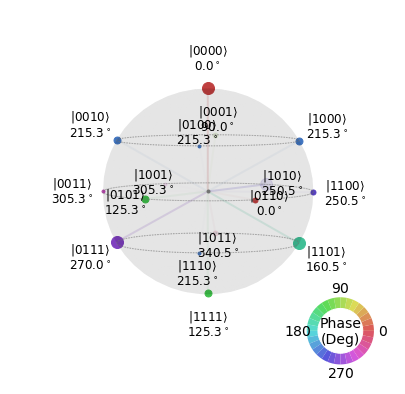

In [2]:
##### build your quantum circuit here
#u = quantum_info.Operator(U)
U = get_unitary()

qc_org = QuantumCircuit(4)
qc_org.unitary(U,[0,1,2,3])
#qc.iso(U,q[:4],q[4:])

# Run the quantum circuit on a statevector simulator backend
backend = Aer.get_backend('statevector_simulator')
job = execute(qc_org, backend)
result = job.result()
state = result.get_statevector(qc_org)
dm = quantum_info.DensityMatrix(state).data
plot_state_qsphere(state, show_state_labels=True, show_state_angles=1) 

# Theory

I started by implementing this [paper](https://arxiv.org/abs/1804.00633). $7$ layers of $U_3$ gates and $CU_3$ and I varaied the targeting quibts in each layer.

Then I started to decrease the number of rotations and the controlled ones till I got $U_3 = 17$ and $ CU_3= 13$.

The pruning process was inspired by the shape of the sandwiched $U$ between Hadamard gates. That's why I kept the first and last 4 $U_3s$. That Approach achieved a cost of $201$ which is great but I cheated a little bit and thresholded all the absolute values below 0.01. That achieved a cost of 132 and an error of $0.006499$.

The optimization process was a bit tedious since the cost funtion was the $\lVert U - V\rVert_2$. This means that i'm going to optimize manay parameters based on somehting like mean squared error function and that's not good at all for convergence.
I used the unitary simulator to get the unitary matrix and just calculated the following cost function
```
np.linalg.norm(U-unit,ord=2)

```
and then I used Sequential Least SQuares Programming (SLSQP) as the optimizer from Aqua since it's fast and it avoided local minima vallies in our problem. Weight initialization was very small so that the optimizer would move freely to the lowest possible point and also to make the weights as sparse as possible so that we can threshold them. 


In [11]:
U = get_unitary()
def qis_circuit(params):
    q = QuantumRegister(4)
    qc = QuantumCircuit(q)
    
    qc.u3(params[0],params[1],params[2],0)
    qc.u3(params[3],params[4],params[5],1)
    qc.u3(params[6],params[7],params[8],2)
    qc.u3(params[9],params[10],params[11],3)
    
    qc.cu3(params[12],params[13],params[14],3,0)
  
    qc.u3(params[15],params[16],params[17],0)
    qc.u3(params[18],params[19],params[20],1)
    qc.cu3(params[21],params[22],params[23],0,2)
    qc.u3(params[24],params[25],params[26],2)
    
    qc.u3(params[27],params[28],params[29],3)
              
    qc.cu3(params[30],params[31],params[32],1,0)
    
    qc.cu3(params[33],params[34],params[35],2,3)
    qc.cu3(params[36],params[37],params[38],3,1)
           
    qc.u3(params[39],params[40],params[41],0)

    qc.u3(params[42],params[43],params[44],1)
    
    qc.cu3(params[45],params[46],params[47],1,2)
    qc.cu3(params[48],params[49],params[50],2,3)

    qc.u3(params[51],params[52],params[53],2)
   
    qc.cu3(params[54],params[55],params[56],0,1)

    qc.cu3(params[57],params[58],params[59],1,3)
    qc.u3(params[60],params[61],params[62],3)
    qc.cu3(params[63],params[64],params[65],3,0)
    
    qc.u3(params[66],params[67],params[68],0)
    qc.cu3(params[69],params[70],params[71],0,2)

    qc.cu3(params[75-3],params[76-3],params[77-3],1,3)
    qc.cu3(params[78-3],params[79-3],params[80-3],2,1)    

    qc.u3(params[81-3],params[82-3],params[83-3],3)
    
    
    qc.u3(params[84-3],params[85-3],params[86-3],0)
    qc.u3(params[87-3],params[88-3],params[89-3],1)
    qc.u3(params[90-3],params[91-3],params[92-3],2)
            
    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend)
    result = job.result()
    return result.get_unitary(qc),qc


def qis_cost(params):
    unit = qis_circuit(params)[0]
    temp = np.linalg.norm(U-unit,ord=2)
    print(temp)
    return temp

In [ ]:
opt = SLSQP(disp=True,tol=1e-13,ftol=1e-13,maxiter=1100)
np.random.seed(70)
x = np.random.uniform(0,0.1,90)
data = opt.optimize(objective_function=qis_cost,num_vars=90,initial_point=x)

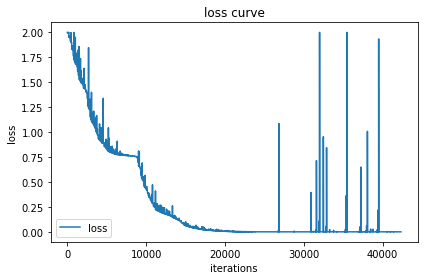

In [12]:
loss_data = pd.read_csv('loss.csv').values
plt.plot(loss_data,label='loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss curve')
plt.legend()
plt.tight_layout()

OrderedDict([('u3', 17), ('cu3', 13)])


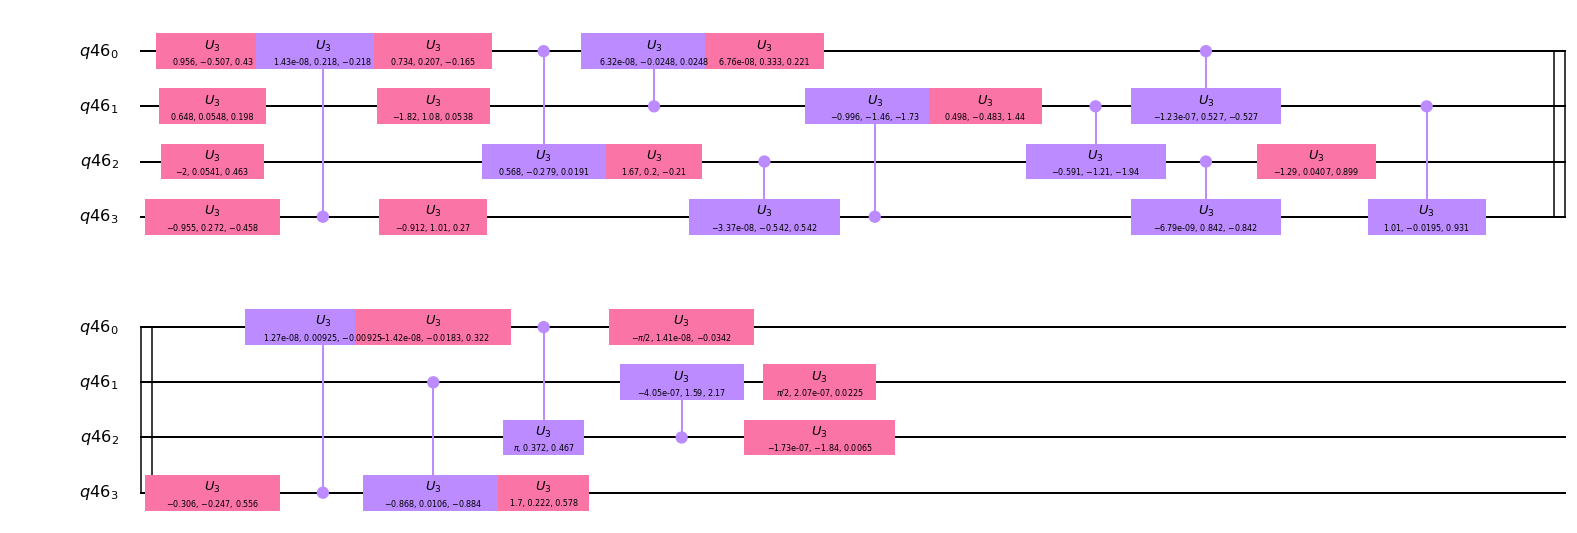

In [13]:
data = np.load('qiskit-challenge-weights.npy',allow_pickle=True)

u = data[0]

complete_circ = qis_circuit(u)[1]

print(complete_circ.count_ops())

complete_circ.draw(output='mpl',scale=0.85)


OrderedDict([('u3', 31), ('cx', 17)])


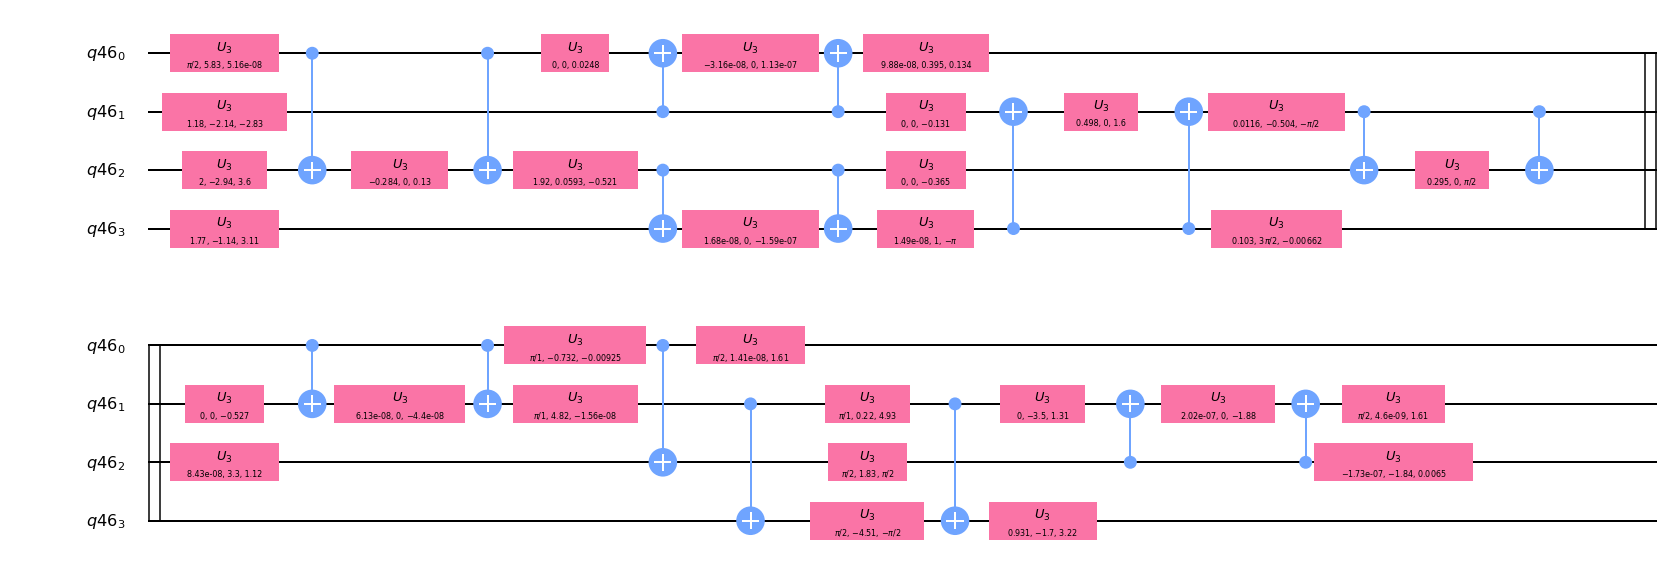

In [14]:
qc = transpile(complete_circ, backend=BasicAer.get_backend('qasm_simulator'), 
                         optimization_level=3,basis_gates=['u3','cx'],seed_transpiler=2)
print(qc.count_ops())
qc.draw('mpl',scale=0.9)

In [15]:
##### check your quantum circuit by running the next line
check_circuit(qc)

Circuit stats:
||U-V||_2 = 3.7789372338197153e-07
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 201

Great! Your circuit meets all the constrains.
Your score is 201. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


OrderedDict([('u3', 17), ('cu3', 13)])
OrderedDict([('u3', 22), ('cx', 11)])
Circuit stats:
||U-V||_2 = 0.006499012124886762
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 132

Great! Your circuit meets all the constrains.
Your score is 132. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!
None


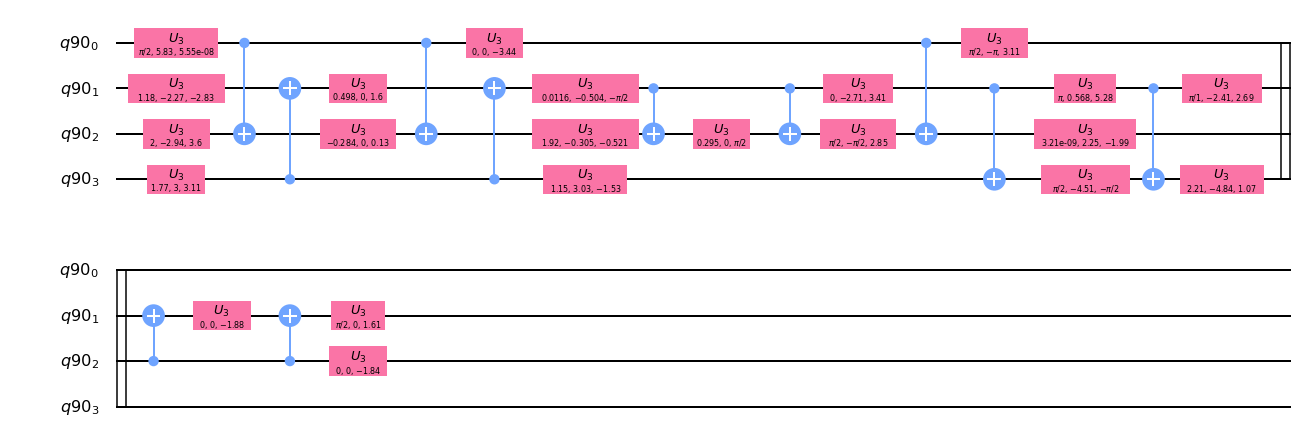

In [16]:
threshold_indices = abs(data[0]) < 0.01

data[0][threshold_indices] = 0 

ff = qis_circuit(data[0])[1]

print(ff.count_ops())

qc = transpile(ff, backend=BasicAer.get_backend('qasm_simulator'), 
                         optimization_level=3,basis_gates=['u3','cx'],seed_transpiler=5)
print(qc.count_ops())

print(check_circuit(qc))

qc.draw('mpl')

You can check whether your circuit is valid before submitting it with `check_circuit(qc)`. Once you have a valid solution, please submit it by running the following cell (delete the `#` before `submit_circuit`). You can re-submit at any time.


In [ ]:
# Send the circuit as the final answer, can re-submit at any time
submit_circuit(qc) 

# analytic solution

In [17]:
h = np.array([[1,1],[1,-1]])
H = np.kron(h,np.kron(h,np.kron(h,h)))/4
U = get_unitary()
print(np.round(U,4))
print(" ....... ")
U = H@U@H
print(np.round(U,4))
print("......")
q = QuantumRegister(4)
qc = QuantumCircuit(q)
qc.u3(pi/2,0,pi,0)
qc.u3(pi/2,0,pi,1)
qc.u3(pi/2,0,pi,2)
qc.u3(pi/2,0,pi,3)
qc.isometry(U,q[:4],[])
qc.u3(pi/2,0,pi,0)
qc.u3(pi/2,0,pi,1)
qc.u3(pi/2,0,pi,2)
qc.u3(pi/2,0,pi,3)

qc = transpile(qc, backend=BasicAer.get_backend('qasm_simulator'), 
                         optimization_level=3,basis_gates=['u3','cx'])
print(qc.count_ops())
#qc.draw()
check_circuit(qc)



[[-0.2134+0.3384j -0.1402-0.0884j  0.2134-0.0884j  0.0366+0.0884j
   0.0884-0.0366j -0.0884-0.2134j -0.0884+0.1402j  0.3384+0.2134j
   0.2134-0.0884j  0.0366+0.0884j  0.3902+0.0884j -0.0366+0.1616j
   0.1616+0.0366j  0.0884-0.3902j  0.0884-0.0366j -0.0884-0.2134j]
 [-0.1402-0.0884j -0.2134+0.3384j  0.0366+0.0884j  0.2134-0.0884j
  -0.0884-0.2134j  0.0884-0.0366j  0.3384+0.2134j -0.0884+0.1402j
   0.0366+0.0884j  0.2134-0.0884j -0.0366+0.1616j  0.3902+0.0884j
   0.0884-0.3902j  0.1616+0.0366j -0.0884-0.2134j  0.0884-0.0366j]
 [ 0.2134-0.0884j  0.0366+0.0884j -0.2134+0.3384j -0.1402-0.0884j
  -0.0884+0.1402j  0.3384+0.2134j  0.0884-0.0366j -0.0884-0.2134j
   0.3902+0.0884j -0.0366+0.1616j  0.2134-0.0884j  0.0366+0.0884j
   0.0884-0.0366j -0.0884-0.2134j  0.1616+0.0366j  0.0884-0.3902j]
 [ 0.0366+0.0884j  0.2134-0.0884j -0.1402-0.0884j -0.2134+0.3384j
   0.3384+0.2134j -0.0884+0.1402j -0.0884-0.2134j  0.0884-0.0366j
  -0.0366+0.1616j  0.3902+0.0884j  0.0366+0.0884j  0.2134-0.0884j
  -0.08

OrderedDict([('u3', 18), ('cx', 13)])
Circuit stats:
||U-V||_2 = 7.802192551692307e-15
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 148

Great! Your circuit meets all the constrains.
Your score is 148. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!
